In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from scipy.signal import convolve2d as conv2
from scipy.fft import fft2, ifft2
from skimage.util import random_noise
from skimage.restoration import wiener, richardson_lucy, denoise_tv_chambolle

# helper function for forward operator
def K(inp,psf=[],mode='forward'):
    n = inp.shape[0]
    k_hat = fft2(psf,s=(n,n))
    inp_hat = fft2(inp)
    if mode == 'forward':
        outp = ifft2(k_hat * inp_hat)
    if mode == 'adjoint':
        outp = ifft2(np.conj(k_hat) * inp_hat)
    if mode == 'inv':
        outp = ifft2( np.conj(k_hat) * inp_hat / ( np.conj(k_hat) * k_hat + 1e-16) )
        
    return np.real(outp)

# helper function for plotting
def plot_images(images, titles, fname=[], scale = [0,1]):
    m = len(images)
    fig, ax = plt.subplots(1,m)
    
    if m > 1:
        for k in range(m):
            ax[k].set_xticks([])
            ax[k].set_yticks([])
            ax[k].imshow(images[k], cmap=plt.cm.gray, vmin=scale[0], vmax=scale[1])
            ax[k].set_title(titles[k])
    else:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(images[0], cmap=plt.cm.gray, vmin=scale[0], vmax=scale[1])
        ax.set_title(titles[0])
    fig.set_figwidth(10)
    fig.tight_layout()
    
    if fname:
        plt.savefig(fname,dpi=300)
        
def squares_image(n):
    u = np.zeros((n,n))
    u[n//6:n//6+n//2, n//6:n//6+n//2] = .5
    u[2*n//3-n//6:2*n//3+n//6, 2*n//3-n//6:2*n//3+n//6] = 1
    
    return u

# Non-linear filters 

To succesfully denoise images, we need to preserve edges.

* The linear filter then solves

$$\min_u \frac{1}{2}\|u - f^\delta\|_2^2 + \alpha \|Ru\|_2^2.$$


* This would simply remove high-frequency content, thereby smoothing out edges:

$$\widetilde{u} = \left(I + \alpha R^*\!R\right)^{-1}f^\delta$$

* A famous *non-linear* filter is Total Variation:

$$\min_u \frac{1}{2}\|u - f^\delta\|_2^2 + \alpha \|\nabla u\|_1.$$


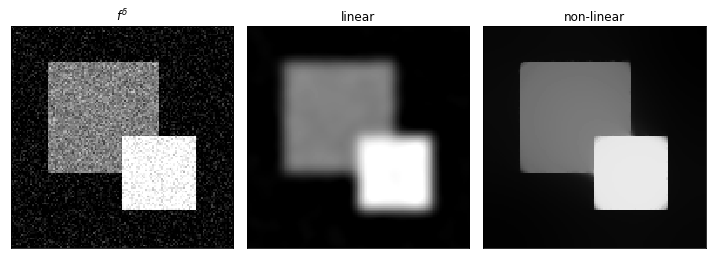

In [3]:
# make image
n = 128
u = squares_image(n)

# add_noise
delta = 1e-1
f_delta = u + delta * np.random.randn(n,n)

# filter
alpha_linear = 50
alpha_nonlinear = 1

psf = np.array([[0,0,0],[0,1,0],[0,0,0]])
reg_psf = np.array([[0,1,0],[1,-4,1],[0,1,0]])

u_linear = wiener(f_delta, psf, balance = alpha_linear, reg = reg_psf, clip=False)
u_nonlinear = denoise_tv_chambolle(f_delta, weight = alpha_nonlinear, eps=1e-6, n_iter_max=5000)

# plot
plot_images([f_delta,u_linear,u_nonlinear], [r'$f^\delta$',r'linear','non-linear'])

## A key ingredient is *sparsity*


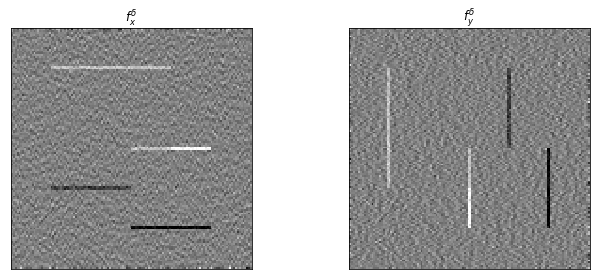

In [8]:
# make image
n = 128
u = squares_image(n)

# add noise
delta = .01
f_delta = random_noise(u, var = delta, clip=False)

# gradient
fx = np.gradient(f_delta, axis=0)
fy = np.gradient(f_delta, axis=1)

# plot
plot_images([fx, fy], [r'$f^\delta_x$',r'$f^\delta_y$'], fname='gradients_noise.png', scale=[-.5,.5])

## Why do we get a sparse solution?

* The $\ell_1$ penalty puts more weight on small entries and less on large ones as compared to $\ell_2$
* A minimum $\ell_1$-solution is more likely to be sparse than a minimum $\ell_2$ solution

## Assignment: TV denoising

* investigate effect of contrast vs. noise
* investigate bias-variance trade-off
* investigate performance of TV on more complex images (see an overview of benchmark images [here](https://scikit-image.org/docs/dev/api/skimage.data.html))


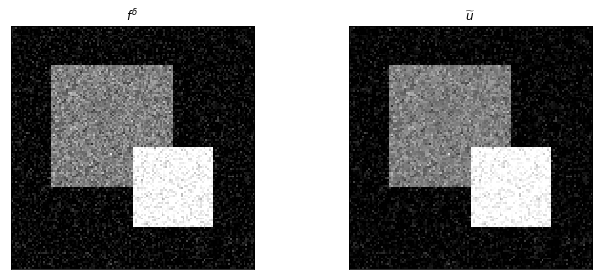

In [14]:
# make image
n = 128
u = squares_image(n)

# add_noise
delta = 1e-1
f_delta = u + delta * np.random.randn(n,n)

# filter
alpha = 1e-2
u_est = denoise_tv_chambolle(f_delta, weight = alpha, eps=1e-6, n_iter_max=5000)

# plot
plot_images([f_delta,u_est], [r'$f^\delta$',r'$\widetilde{u}$'])